In [1]:
import numpy as np
import pylab as plt 
import mne

mne.set_log_level('critical') # limits MNE's verbosity
%matplotlib inline

# install non standard modules 
!pip install git+git://github.com/renzocom/PCIst 
!pip install bitarray # works on HBP collab

# import the installed modules 
from PCIst import pci_st
from bitarray import bitarray

# import util functions 
import util_files.PCIevoked_uti as uti


  Cloning git://github.com/renzocom/PCIst to /tmp/pip-req-build-avvc8ahy
fatal: unable to connect to github.com:
github.com: Temporary failure in name resolution

Command "git clone -q git://github.com/renzocom/PCIst /tmp/pip-req-build-avvc8ahy" failed with error code 128 in None
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# path to data 
fnWake='data/EVKD_1450Hz_single_trial-wake-epo.fif'
fnSleep='data/EVKD_1450Hz_single_trial-sleep-epo.fif'
sfreq=1450 # sampling frequency 
uti.decimate=4 # decimate signal (if 0 keep signals at the original sampling rate)

# forward model
uti.fn_forward='util_files/fsaverage-324nodes-fwd.fif'
nodes=324 # number of vertices 

# parameters of the inverse solution 
uti.snr=3
uti.method='sLORETA' 

# parameters for PCIst 
par_PCIst = {'baseline_window':(-400,-50), 'response_window':(0,300), 'k':1.2, 'min_snr':1.1, 'max_var':99, 'embed':False,'n_steps':100}

# general parameters
times_vis=[-0.1,0,0.01,0.025,0.05,0.075,0.1,0.125] # time points for topography 

# Load EEG data and compute cortical currents

In [3]:
dataEEG_w,stcEVK_w,_,_=uti.compute_inverse(fnWake) 
dataEEG_s,stcEVK_s,_,_=uti.compute_inverse(fnSleep)

# TMS/EEG data at a glance

As a first step let us have a look to the topographies of the evoked EEG activities. At a first glance, the activity evoked activities are much richer during the wake state than during the sleep state. 

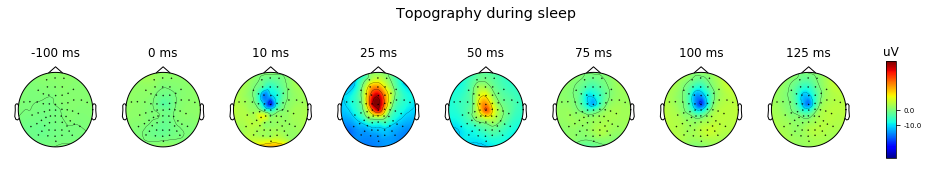

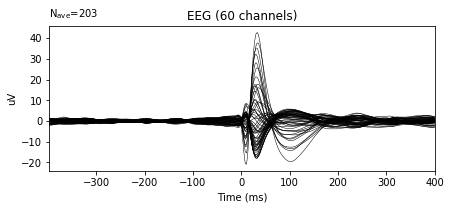

In [4]:
evoked_s=dataEEG_s.average() 
evoked_s.plot_topomap(times=times_vis,ch_type='eeg',cmap='jet', time_unit='ms',title='Topography during sleep')
evoked_s.plot(time_unit='ms')
plt.show()

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }

<IPython.core.display.Javascript object>

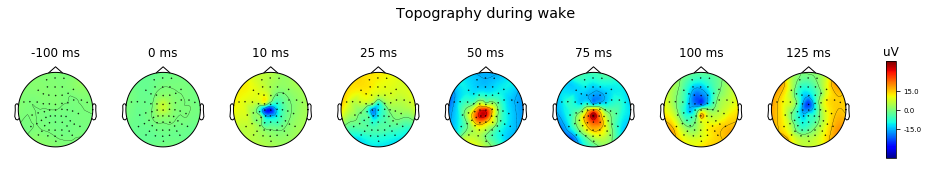

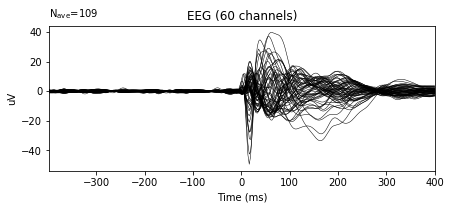

In [6]:
evoked_w=dataEEG_w.average() 
evoked_w.plot_topomap(times=times_vis,ch_type='eeg',cmap='jet', time_unit='ms',title='Topography during wake')
evoked_w.plot(time_unit='ms')
plt.show()

# Compute PCIst

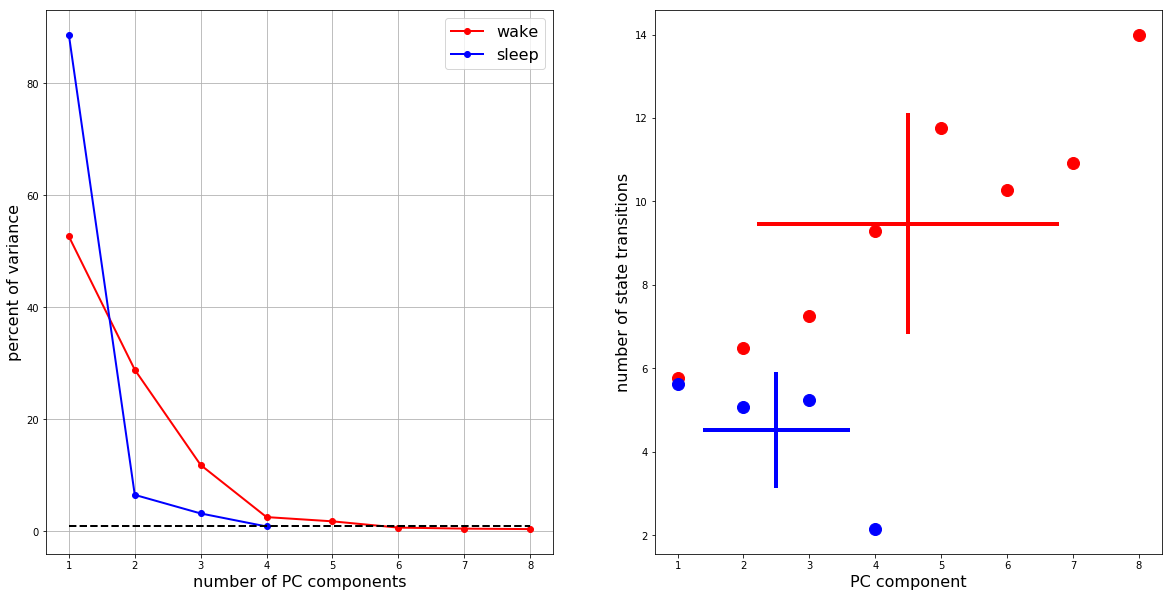

PCIst(wake) = 75.7622
PCIst(sleep) = 18.0692


In [24]:
times_ms=stcEVK_w.times*1e3
pciST_wake = pci_st.calc_PCIst(evoked_w.data,times_ms, **par_PCIst, full_return=True) # PCIst.pci_st.
pciST_sleep = pci_st.calc_PCIst(evoked_s.data,times_ms, **par_PCIst, full_return=True) # PCIst.pci_st
N_wake=pciST_wake['signal_svd'].shape[0]
N_sleep=pciST_sleep['signal_svd'].shape[0]
x_wake=np.arange(N_wake)+1
x_sleep=np.arange(N_sleep)+1
# plot 
plt.figure(figsize=(20,10)) 
plt.subplot(121)
plt.plot(x_wake,pciST_wake['var_exp'],'ro-',lw=2,label='wake')
plt.plot(x_sleep,pciST_sleep['var_exp'],'bo-',lw=2,label='sleep')
plt.plot([1,N_wake],[1,1],'k--',lw=2)
plt.xlabel('number of PC components',fontsize=16)
plt.ylabel('percent of variance',fontsize=16)
plt.grid()
plt.legend(loc=1,fontsize=16)
plt.subplot(122)
plt.plot(x_wake,pciST_wake['dNST'],'ro',markersize=12)
mx,my,sx,sy=np.mean(x_wake),np.mean(pciST_wake['dNST']),np.std(x_wake),np.std(pciST_wake['dNST'])
plt.errorbar(x=mx,y=my,xerr=sx,yerr=sy,ecolor='r',color='r',linewidth=4,elinewidth=4)
plt.plot(x_sleep,pciST_sleep['dNST'],'bo',markersize=12)
mx,my,sx,sy=np.mean(x_sleep),np.mean(pciST_sleep['dNST']),np.std(x_sleep),np.std(pciST_sleep['dNST'])
plt.errorbar(x=mx,y=my,xerr=sx,yerr=sy,ecolor='b',color='b',linewidth=4,elinewidth=4)
plt.xlabel('PC component',fontsize=16)
plt.ylabel('number of state transitions',fontsize=16)
plt.show()

print("PCIst(wake) = %g"%np.sum(pciST_wake['dNST']))
print("PCIst(sleep) = %g"%np.sum(pciST_sleep['dNST']))

# PCI evoked (ev)

Determine the significant activations during wake and sleep.

In [29]:
t_stop=300 # ms 
# wake
J_w=stcEVK_w.data
t_w=stcEVK_w.times*1000.    # s -> ms 
idx_w=np.where(t_w<t_stop)[0]
t_w=t_w[idx_w]
J_w=J_w[:,idx_w]
TTiafft_w=uti.Threshold_IAFFT(J_w,t_w,uti.params)
binJiafft_w=uti.Build_binJ(t_w,J_w,TTiafft_w)
binJiafft_w=uti.sort_binJ(binJiafft_w)
sign_row_w,sign_col_w=np.where(binJiafft_w)
# sleep
J_s=stcEVK_s.data
t_s=stcEVK_s.times*1000.    # s -> ms 
idx_s=np.where(t_s<t_stop)[0]
t_s=t_s[idx_s]
J_s=J_s[:,idx_s]
TTiafft_s=uti.Threshold_IAFFT(J_s,t_s,uti.params)
binJiafft_s=uti.Build_binJ(t_s,J_s,TTiafft_s)
binJiafft_s=uti.sort_binJ(binJiafft_s)
sign_row_s,sign_col_s=np.where(binJiafft_s)

Plot the significant activations.

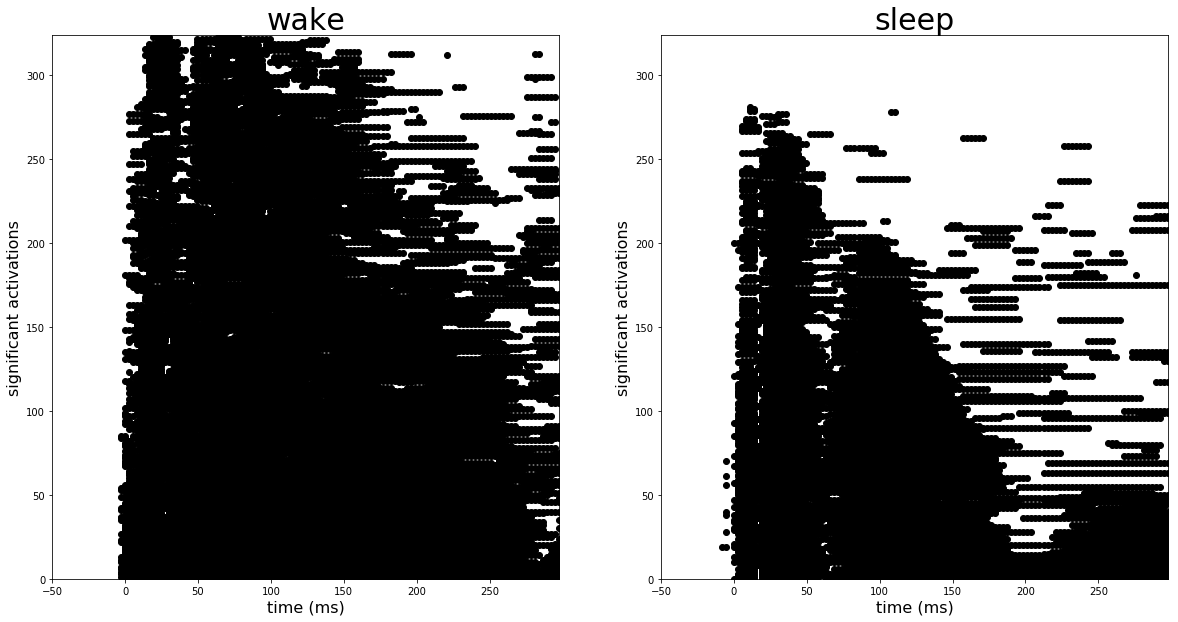

In [32]:
plt.figure(figsize=(20,10)) 

plt.subplot(1,2,1)
plt.plot(t_w[sign_col_w],sign_row_w,'ko')
plt.xlabel('time (ms)',fontsize=16)
plt.ylabel('significant activations',fontsize=16)
plt.xlim(t_w.min(),t_w.max())
plt.ylim(0,nodes)
plt.xlim(xmin=-50)
plt.title('wake',fontsize=30)

plt.subplot(1,2,2)
plt.plot(t_s[sign_col_s],sign_row_s,'ko')
plt.xlabel('time (ms)',fontsize=16)
plt.ylabel('significant activations',fontsize=16)
plt.xlim(t_s.min(),t_s.max())
plt.ylim(0,nodes)
plt.xlim(xmin=-50)
plt.title('sleep',fontsize=30)
plt.show()

Compute temporal evolution of PCI & plot it.

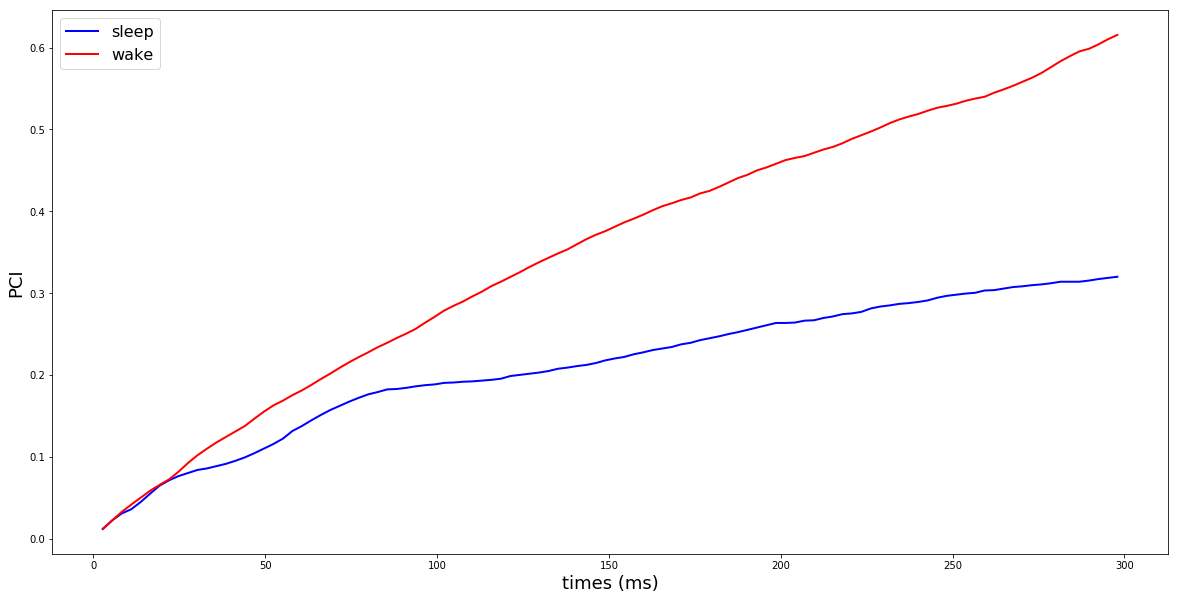

In [33]:
idx_s=np.where(t_s>0)[0]
idx_w=np.where(t_w>0)[0]

PCIs=uti.PCIlz(binJiafft_s[:,idx_s])
PCIw=uti.PCIlz(binJiafft_w[:,idx_w])

plt.figure(figsize=(20,10))
plt.plot(t_s[idx_s],PCIs,'b-',lw=2,label='sleep')
plt.plot(t_w[idx_w],PCIw,'r-',lw=2,label='wake')
plt.xlabel('times (ms)',fontsize=18)
plt.ylabel('PCI',fontsize=18)
plt.legend(loc=2,fontsize=16)
plt.show()

References:

[1] A Theoretically Based Index of Consciousness Independent of Sensory Processing and Behavior. A G Casali, O Gosseries, M Rosanova, M Boly, S Sarasso, K R Casali, S Casarotto, M Bruno, S Laureys, G Tononi, M Massimini. Sci Transl Med. 2013 Aug 14;5(198):198ra105. doi: 10.1126/scitranslmed.3006294.
[2]  A fast and general method to empirically estimate the complexity of brain responses to transcranial and intracranial stimulations. Comolatti, R., Pigorini, A., Casarotto, S., Fecchio, M., Faria, G., Sarasso, S., et al. (2019). Brain Stimulation, S1935861X19302207. doi:10.1016/j.brs.2019.05.013.